In [2]:
import os
import cv2
import numpy as np

def load_images_from_paths(image_paths):
    """
    Carrega imagens a partir de uma lista de caminhos e retorna uma lista de arrays numpy.

    Args:
        image_paths (list of str): Lista de caminhos para imagens.

    Returns:
        list: Lista de arrays numpy representando as imagens carregadas.
    """
    images = []
    for image_path in image_paths:
        abs_path = os.path.abspath(image_path)
        if not os.path.exists(abs_path):
            print(f"[ERRO] Arquivo não encontrado: {abs_path}")
            continue
        img = cv2.imread(abs_path)
        if img is not None:
            images.append(img)
        else:
            print(f"[ERRO] Falha ao carregar imagem (formato inválido?): {abs_path}")
    return images
# Defina o caminho para o diretório de imagens
paths = [
    '../defungi_dataset/BBH/H6_4b_4.jpg',
    '../defungi_dataset/GMA/H3_3a_10.jpg',
    '../defungi_dataset/SHC/H5_104a_2.jpg',
    '../defungi_dataset/BBH/H6_52a_13.jpg',
    '../defungi_dataset/GMA/H3_25a_2.jpg',
    '../defungi_dataset/BBH/H6_56b_2.jpg',
    '../defungi_dataset/TSH/H1_116b_11.jpg',
    '../defungi_dataset/SHC/H5_36a_4.jpg',
]

images = load_images_from_paths(paths)

    # Exiba o número de imagens carregadas
print(f"Total de imagens carregadas do diretório {paths}: {len(images)}")

# Exiba o número de imagens carregadas
print(f"Total de imagens carregadas: {len(images)}")

Total de imagens carregadas do diretório ['../defungi_dataset/BBH/H6_4b_4.jpg', '../defungi_dataset/GMA/H3_3a_10.jpg', '../defungi_dataset/SHC/H5_104a_2.jpg', '../defungi_dataset/BBH/H6_52a_13.jpg', '../defungi_dataset/GMA/H3_25a_2.jpg', '../defungi_dataset/BBH/H6_56b_2.jpg', '../defungi_dataset/TSH/H1_116b_11.jpg', '../defungi_dataset/SHC/H5_36a_4.jpg']: 8
Total de imagens carregadas: 8


In [3]:
import matplotlib.pyplot as plt
    
def plot_image_grid(images, nrows=None, ncols=None, size=128):
    if nrows is None:
        nrows = 1
    if ncols is None:
        ncols = len(images)

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 2, nrows * 2))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < len(images):
            img = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)  # BGR → RGB para mostrar corretamente
            ax.imshow(img)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

In [4]:
def increase_saturation(image, value=50):
    """
    Aumenta a saturação da imagem.

    Args:
        image (np.ndarray): Imagem em BGR.
        value (int): Valor a ser adicionado à saturação (0–255).

    Returns:
        np.ndarray: Imagem com saturação aumentada.
    """
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    
    # Adiciona valor com saturação limitada a 255
    s = np.clip(s.astype(np.int32) + value, 0, 255).astype(np.uint8)
    
    hsv_saturated = cv2.merge((h, s, v))
    return cv2.cvtColor(hsv_saturated, cv2.COLOR_HSV2BGR)


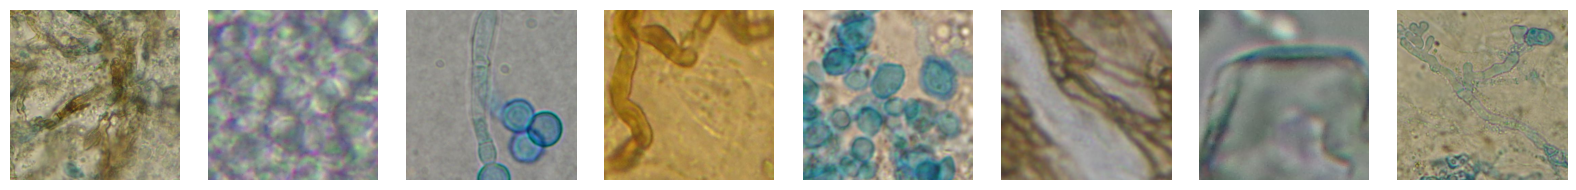

In [5]:
plot_image_grid(images=images)


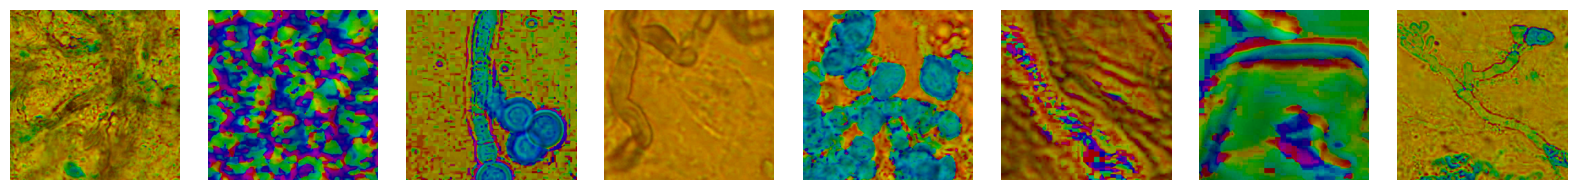

In [6]:
images_saturated = [increase_saturation(img, value=255) for img in images]
plot_image_grid(images=images_saturated)

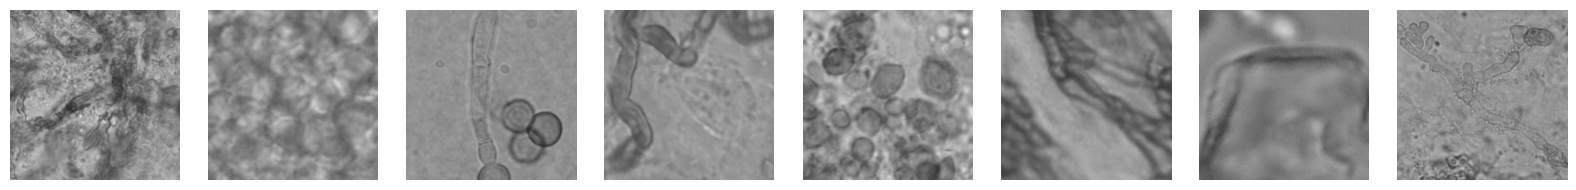

In [7]:
images_gray = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in images]
plot_image_grid(images=images_gray, ncols=8, nrows=1)

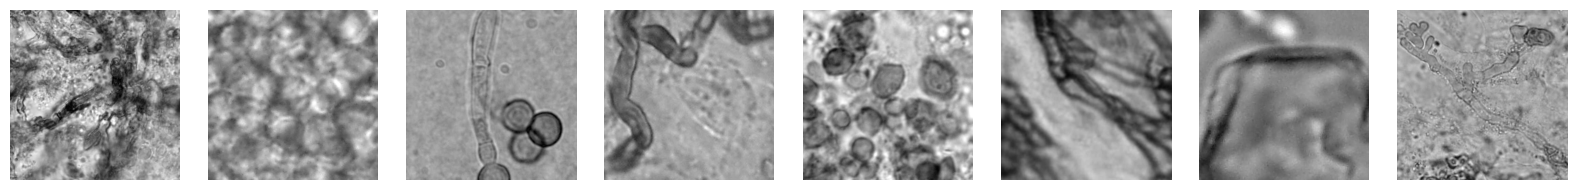

In [8]:
images_brightness_fix = [cv2.convertScaleAbs(image, alpha=1.7, beta=-90) for image in images_gray]
plot_image_grid(images=images_brightness_fix, ncols=8, nrows=1)

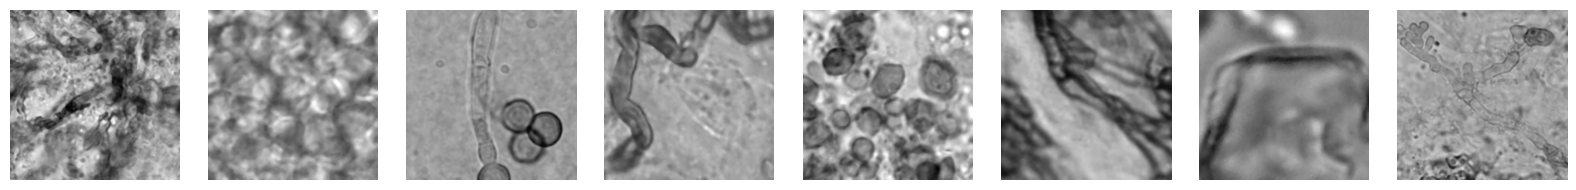

In [9]:
images_median_filtered = [cv2.medianBlur(image, ksize=7) for image in images_brightness_fix]
plot_image_grid(images=images_median_filtered)

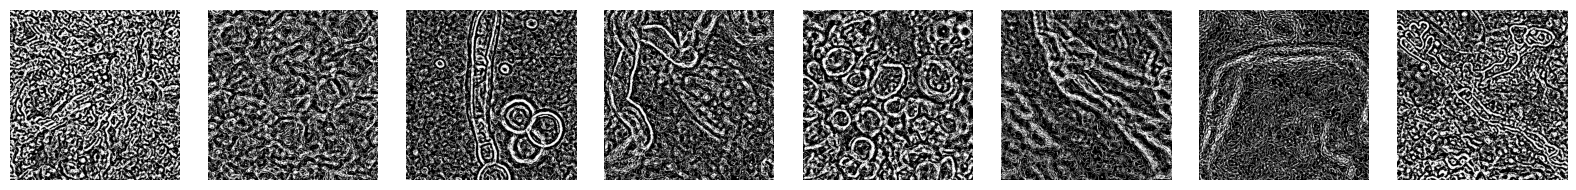

In [10]:
# Aplicar limiarização adaptativa
    # cv2.ADAPTIVE_THRESH_GAUSSIAN_C ou cv2.ADAPTIVE_THRESH_MEAN_C
    # cv2.THRESH_BINARY_INV para que o fundo claro vire preto e o objeto escuro vire branco
    # blockSize: Tamanho da vizinhança que o limiar adaptativo irá considerar (deve ser ímpar e > 1)
    # C: Constante subtraída da média ou média ponderada (você pode ajustar este valor, e.g., 2, 5, 10)
images_binary = [cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,7, 1) for img in images_median_filtered]
plot_image_grid(images=images_binary)

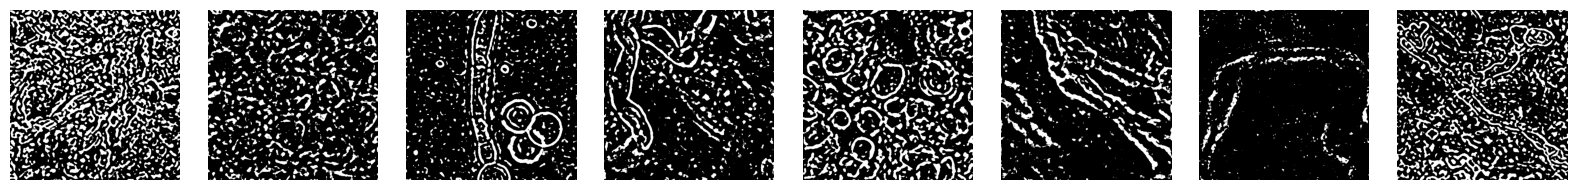

In [11]:
images_median_binared = [cv2.medianBlur(image, ksize=7) for image in images_binary]
plot_image_grid(images=images_median_binared)

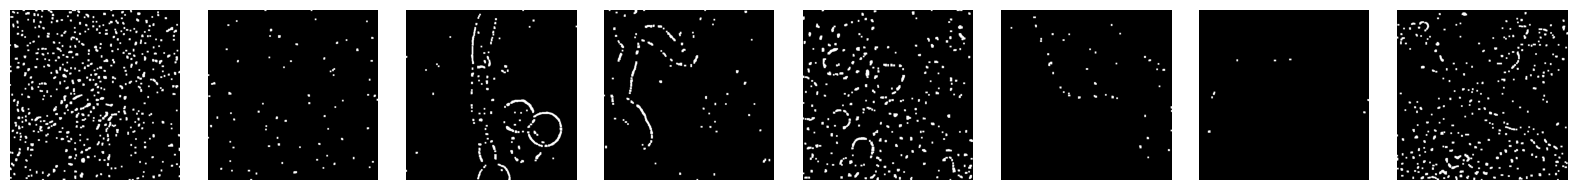

In [12]:
# Defina o kernel para a operação morfológica
kernel_open = np.ones((5,5), np.uint8) # Você pode ajustar o tamanho do kernel, e.g., (5,5)

# Aplica a operação de Abertura nas imagens binarizadas
images_opened = [cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel_open) for image in images_binary]
plot_image_grid(images=images_opened)

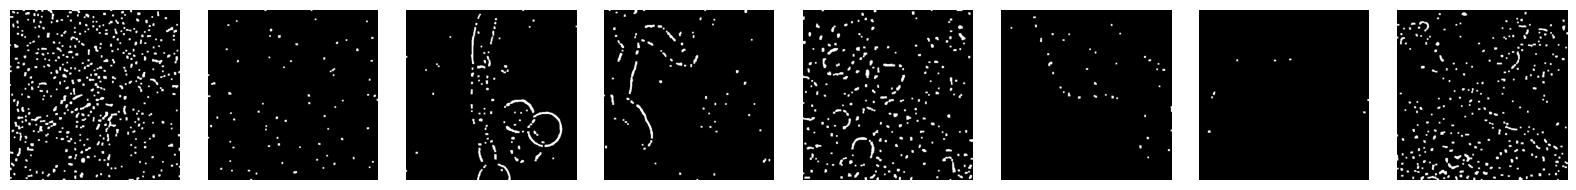

In [13]:
# Defina o kernel para a operação morfológica
kernel_close = np.ones((5,5), np.uint8) # Você pode ajustar o tamanho do kernel, e.g., (5,5)

# Aplica a operação de Fechamento nas imagens após a abertura
images_closed = [cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel_close) for image in images_opened]
plot_image_grid(images=images_closed)

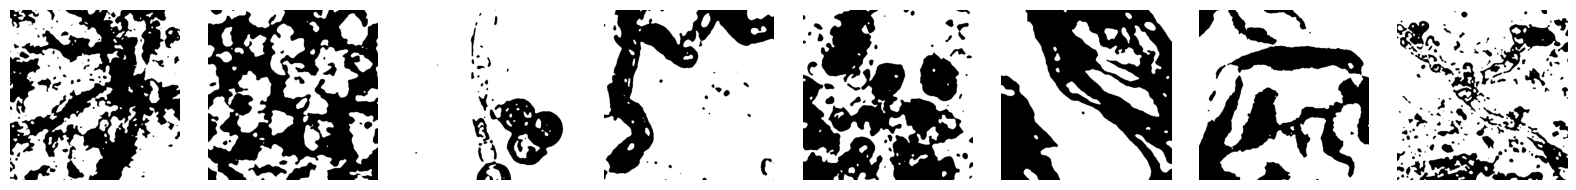

In [14]:
images_binary = [cv2.threshold(img, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU )[1] for img in images_median_filtered]
plot_image_grid(images=images_binary)

# Trabalho de processamento de dados

## Duplicação para pasta das imagens processadas

In [15]:
#Duplicação para pasta das imagens processadas

def save_images_on_folder(images_with_names, folder_path):
    os.makedirs(folder_path, exist_ok=True)
    for nome_arquivo, imagem in images_with_names:
        file_path = os.path.join(folder_path, nome_arquivo)
        # Sobrescreve caso já esteja criado
        cv2.imwrite(file_path, imagem)
        print(f"[INFO] Imagem salva (sobrescrito se já existia): {file_path}")

def get_path_folder(folder_name):
    """
    Retorna o caminho absoluto para um diretório específico dentro do diretório atual.

    Args:
        folder_name (str): Nome do diretório.

    Returns:
        str: Caminho absoluto para o diretório.
    """
    dicionario = {
        "BASH" : "../processed_dataset/BASH",
        "BBH" : "../processed_dataset/BBH",
        "GMA" : "../processed_dataset/GMA",
        "SHC" : "../processed_dataset/SHC",
        "TSH" : "../processed_dataset/TSH"
    }
    resultado = dicionario[folder_name]
    return resultado

## Pré-processamento

### Load das imagens

In [16]:
import os
import cv2
import numpy as np

def load_images_from_paths(image_paths):
    """
    Carrega imagens a partir de uma lista de caminhos e retorna uma lista de arrays numpy.

    Args:
        image_paths (list of str): Lista de caminhos para imagens.

    Returns:
        list: Lista de arrays numpy representando as imagens carregadas.
    """
    images_2 = []
    for image_path in image_paths:
        abs_path = os.path.abspath(image_path)
        if not os.path.exists(abs_path):
            print(f"[ERRO] Arquivo não encontrado: {abs_path}")
            continue
        img = cv2.imread(abs_path)
        if img is not None:
            images.append(img)
        else:
            print(f"[ERRO] Falha ao carregar imagem (formato inválido?): {abs_path}")
    return images
# Defina o caminho para o diretório de imagens
paths = [
    '../defungi_dataset/BBH/H6_4b_4.jpg',
    '../defungi_dataset/GMA/H3_3a_10.jpg',
    '../defungi_dataset/SHC/H5_104a_2.jpg',
    '../defungi_dataset/BBH/H6_52a_13.jpg',
    '../defungi_dataset/GMA/H3_25a_2.jpg',
    '../defungi_dataset/BBH/H6_56b_2.jpg',
    '../defungi_dataset/TSH/H1_116b_11.jpg',
    '../defungi_dataset/SHC/H5_36a_4.jpg',
]

images_2 = load_images_from_paths(paths)

    # Exiba o número de imagens carregadas
print(f"Total de imagens carregadas do diretório {paths}: {len(images_2)}")

# Exiba o número de imagens carregadas
print(f"Total de imagens carregadas: {len(images_2)}")

Total de imagens carregadas do diretório ['../defungi_dataset/BBH/H6_4b_4.jpg', '../defungi_dataset/GMA/H3_3a_10.jpg', '../defungi_dataset/SHC/H5_104a_2.jpg', '../defungi_dataset/BBH/H6_52a_13.jpg', '../defungi_dataset/GMA/H3_25a_2.jpg', '../defungi_dataset/BBH/H6_56b_2.jpg', '../defungi_dataset/TSH/H1_116b_11.jpg', '../defungi_dataset/SHC/H5_36a_4.jpg']: 16
Total de imagens carregadas: 16


In [17]:
def load_folder_from_path(folder_path):
    """
    Carrega todas as imagens de um diretório específico e retorna uma lista de (nome_arquivo, imagem).
    """
    image_names = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    image_paths = [os.path.join(folder_path, name) for name in image_names]
    imagens = [cv2.imread(path, cv2.IMREAD_COLOR) for path in image_paths]
    return list(zip(image_names, imagens))

### Demonstração das imagens

In [18]:
import matplotlib.pyplot as plt
    
def plot_image_grid(images, nrows=None, ncols=None, size=128):
    if nrows is None:
        nrows = 1
    if ncols is None:
        ncols = len(images)

    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 2, nrows * 2))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < len(images):
            img = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)  # BGR → RGB para mostrar corretamente
            ax.imshow(img)
        ax.axis("off")

    plt.tight_layout()
    plt.show()

### Operações

In [19]:
def increase_saturation(image, value=50):
    """
    Aumenta a saturação da imagem.

    Args:
        image (np.ndarray): Imagem em BGR.
        value (int): Valor a ser adicionado à saturação (0–255).

    Returns:
        np.ndarray: Imagem com saturação aumentada.
    """
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    
    # Adiciona valor com saturação limitada a 255
    s = np.clip(s.astype(np.int32) + value, 0, 255).astype(np.uint8)
    
    hsv_saturated = cv2.merge((h, s, v))
    return cv2.cvtColor(hsv_saturated, cv2.COLOR_HSV2BGR)

def go_gray_scale(image):
    """
    Converte a imagem para escala de cinza.

    Args:
        image (np.ndarray): Imagem em BGR.

    Returns:
        np.ndarray: Imagem convertida para escala de cinza.
    """
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

def Lab_channel(image, channel):
    """
    Extrai um canal específico do espaço de cores LAB.

    Args:
        image (np.ndarray): Imagem em BGR.
        channel (str): Canal a ser extraído ('a' ou 'b').

    Returns:
        np.ndarray: Canal extraído da imagem.
    """
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2Lab)
    if channel == 'a':
        return lab[:, :, 1]
    elif channel == 'b':
        return lab[:, :, 2]
    else:
        raise ValueError("Canal deve ser 'a' ou 'b'.")


def HSV_channel(image, channel='h'):
    """
    Extrai um canal específico do espaço de cores HSV.

    Args:
        image (np.ndarray): Imagem em BGR.
        channel (str): Canal a ser extraído ('h', 's' ou 'v').

    Returns:
        np.ndarray: Canal extraído da imagem.
    """
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    if channel == 'h':
        return hsv[:, :, 0]
    elif channel == 's':
        return hsv[:, :, 1]
    elif channel == 'v':
        return hsv[:, :, 2]
    else:
        raise ValueError("Canal deve ser 'h', 's' ou 'v'.")
    
def Hue_fix(image, value):
    """
    Aumenta o valor do canal Hue da imagem.

    Args:
        image (np.ndarray): Imagem em BGR.
        value (int): Valor a ser adicionado ao canal Hue (0–255).

    Returns:
        np.ndarray: Imagem com o canal Hue aumentado.
    """
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    
    # Adiciona valor com Hue limitado a 180
    h = np.clip(h.astype(np.int32) + value, 0, 180).astype(np.uint8)
    
    hsv_hue_fixed = cv2.merge((h, s, v))
    return cv2.cvtColor(hsv_hue_fixed, cv2.COLOR_HSV2BGR)

def Luminosity_fix(image, value):
    """
    Aumenta o valor do canal de luminosidade da imagem.

    Args:
        image (np.ndarray): Imagem em BGR.
        value (int): Valor a ser adicionado ao canal de luminosidade (0–255).

    Returns:
        np.ndarray: Imagem com o canal de luminosidade aumentado.
    """
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    
    # Adiciona valor com luminosidade limitada a 255
    v = np.clip(v.astype(np.int32) + value, 0, 255).astype(np.uint8)
    
    hsv_luminosity_fixed = cv2.merge((h, s, v))
    return cv2.cvtColor(hsv_luminosity_fixed, cv2.COLOR_HSV2BGR)

In [20]:
#Filtros Gaussiano e mediana
def gaussian_filter(image, ksize=(5, 5), sigma=0):
    """
    Aplica um filtro gaussiano na imagem.

    Args:
        image (np.ndarray): Imagem em BGR.
        ksize (tuple): Tamanho do kernel do filtro gaussiano.
        sigma (float): Desvio padrão do filtro gaussiano.

    Returns:
        np.ndarray: Imagem filtrada.
    """
    return cv2.GaussianBlur(image, ksize, sigma)

def median_filter(image, ksize=5):
    """
    Aplica um filtro de mediana na imagem.

    Args:
        image (np.ndarray): Imagem em BGR.
        ksize (int): Tamanho do kernel do filtro de mediana.

    Returns:
        np.ndarray: Imagem filtrada.
    """
    return cv2.medianBlur(image, ksize)


## Detecção de bordas

In [21]:
#Canny Edge Detection
def canny_edge_detection(image, low_threshold=100, high_threshold=200):
    """
    Aplica a detecção de bordas de Canny na imagem.

    Args:
        image (np.ndarray): Imagem em BGR.
        low_threshold (int): Limite inferior para a detecção de bordas.
        high_threshold (int): Limite superior para a detecção de bordas.

    Returns:
        np.ndarray: Imagem com as bordas detectadas.
    """
    return cv2.Canny(image, low_threshold, high_threshold)

# Limiarização
def threshold_otsu(image):
    """
    Aplica a limiarização de Otsu na imagem.

    Args:
        image (np.ndarray): Imagem em escala de cinza.

    Returns:
        np.ndarray: Imagem binarizada.
    """
    _, binary_image = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return binary_image

def adaptive_threshold(image, block_size=11, C=2):
    """
    Aplica a limiarização adaptativa na imagem.

    Args:
        image (np.ndarray): Imagem em escala de cinza.
        block_size (int): Tamanho do bloco para a limiarização adaptativa (deve ser ímpar).
        C (int): Constante subtraída da média ou média ponderada.

    Returns:
        np.ndarray: Imagem binarizada.
    """
    return cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, block_size, C)

## Pós-processamento

In [22]:
def morphological_open(image, kernel_size=(5, 5)):
    """
    Aplica a operação de abertura morfológica na imagem.

    Args:
        image (np.ndarray): Imagem binarizada.
        kernel_size (tuple): Tamanho do kernel para a operação de abertura.

    Returns:
        np.ndarray: Imagem após a operação de abertura.
    """
    kernel = np.ones(kernel_size, np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

def morphological_close(image, kernel_size=(5, 5)):
    """
    Aplica a operação de fechamento morfológico na imagem.

    Args:
        image (np.ndarray): Imagem binarizada.
        kernel_size (tuple): Tamanho do kernel para a operação de fechamento.

    Returns:
        np.ndarray: Imagem após a operação de fechamento.
    """
    kernel = np.ones(kernel_size, np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)



# Segmentação

In [23]:
def segmentação_kmeans(images, k=5, attempts=10, max_iter=100):
    """
    Aplica segmentação K-means nas imagens.

    Args:
        images (list of np.ndarray): Lista de imagens em BGR.
        k (int): Número de clusters para K-means.
        attempts (int): Número de tentativas para encontrar o melhor resultado.
        max_iter (int): Número máximo de iterações.

    Returns:
        list: Lista de imagens segmentadas.
    """
    segmented_images = []
    for img in images:
        Z = img.reshape((-1, 3))
        Z = np.float32(Z)
        
        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, max_iter, 0.2)
        _, label, center = cv2.kmeans(Z, k, None, criteria, attempts, cv2.KMEANS_RANDOM_CENTERS)
        
        center = np.uint8(center)
        segmented_img = center[label.flatten()].reshape(img.shape)
        segmented_images.append(segmented_img)
    
    return segmented_images

## Testes

### Teste 1

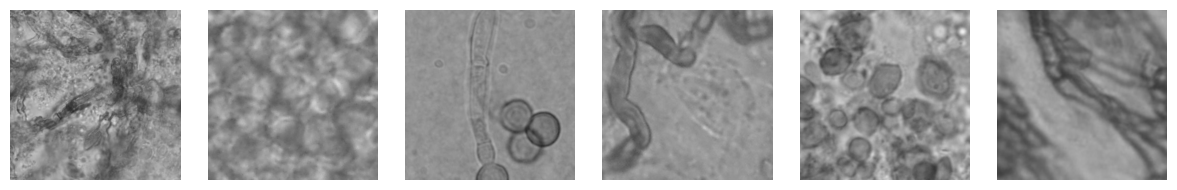

In [24]:
images_2_gray = [go_gray_scale(img) for img in images_2]
plot_image_grid(images=images_2_gray, ncols=6, nrows=1)

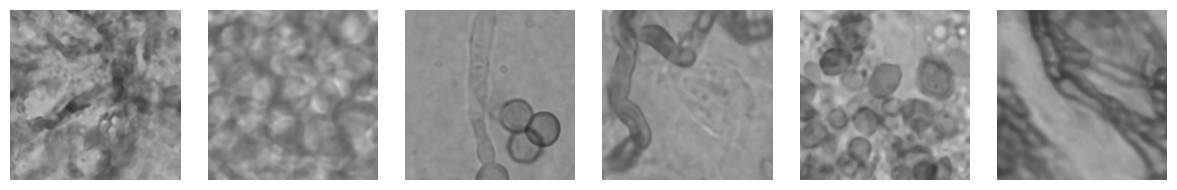

In [25]:
images_2_median = [median_filter(img, ksize=11) for img in images_2_gray]
plot_image_grid(images=images_2_median, ncols=6, nrows=1)

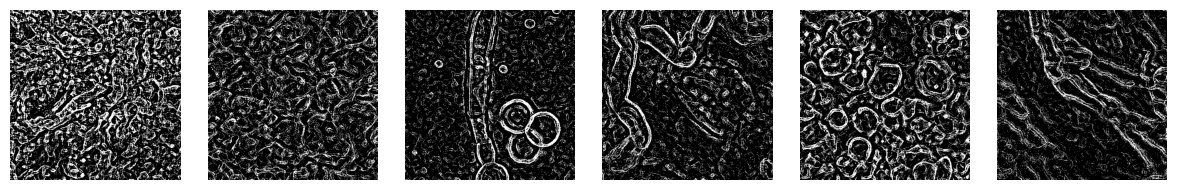

In [26]:
imagens_2_limiarized = [adaptive_threshold(img, block_size=7, C=1) for img in images_2_median]
plot_image_grid(images=imagens_2_limiarized, ncols=6, nrows=1)

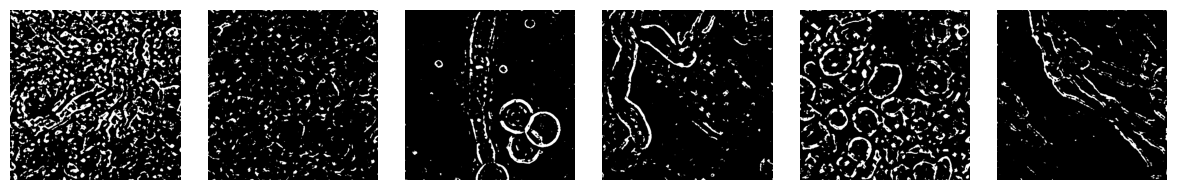

In [33]:
imagens_2_median_limiarized = [median_filter(img, 5) for img in imagens_2_limiarized]
plot_image_grid(images=imagens_2_median_limiarized, ncols=6, nrows=1)

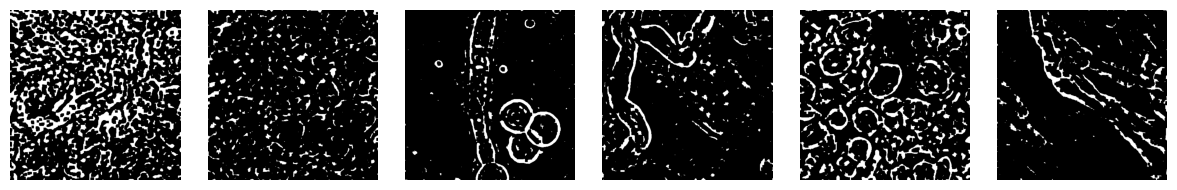

In [34]:
imagens_2_close = [morphological_close(img, kernel_size=(7,7)) for img in imagens_2_median_limiarized]
plot_image_grid(imagens_2_close, ncols=6, nrows=1)

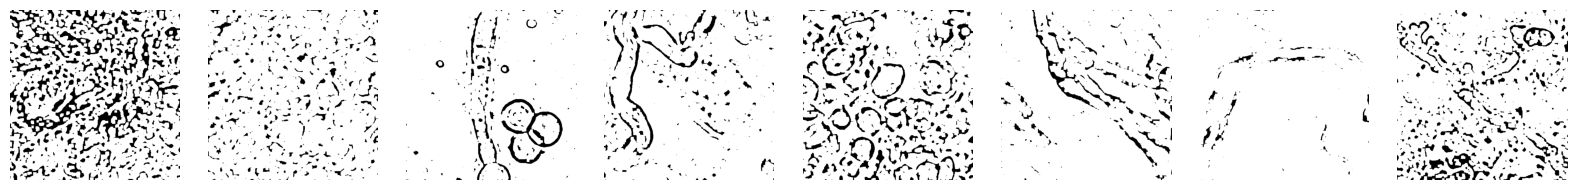

In [38]:
imagens_2_inverted = [cv2.bitwise_not(img) for img in imagens_2_close]
plot_image_grid(images=imagens_2_inverted, ncols=8, nrows=1)

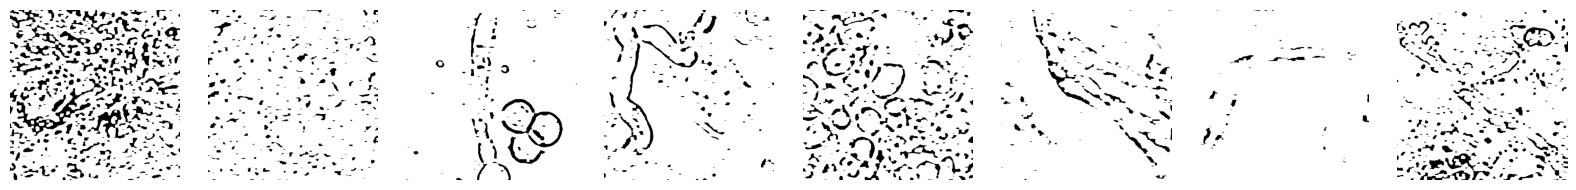

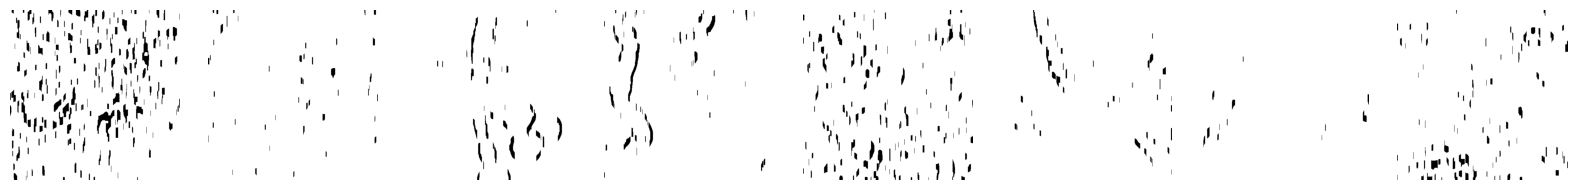

In [41]:
# Fechamento horizontal (kernel 1x15)
kernel_horizontal = np.ones((1, 5), np.uint8)
images_closed_horizontal = [cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel_horizontal) for img in imagens_2_inverted]
plot_image_grid(images=images_closed_horizontal, ncols=8, nrows=1)

# Fechamento vertical (kernel 15x1)
kernel_vertical = np.ones((15, 1), np.uint8)
images_closed_vertical = [cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel_vertical) for img in imagens_2_inverted]
plot_image_grid(images=images_closed_vertical, ncols=8, nrows=1)

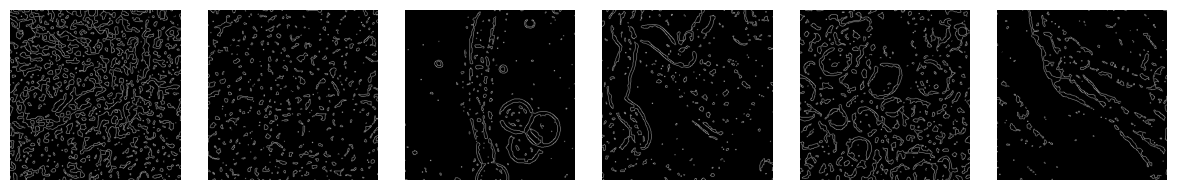

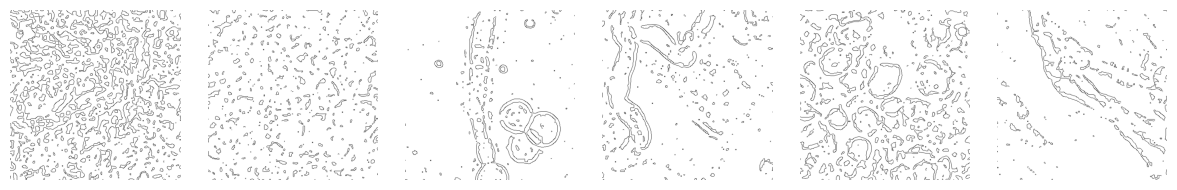

In [42]:
imagens_2_canny = [canny_edge_detection(img, low_threshold=100, high_threshold=200) for img in imagens_2_inverted]
plot_image_grid(images=imagens_2_canny, ncols=6, nrows=1)

imagens_2_canny_inverted = [cv2.bitwise_not(img) for img in imagens_2_canny]
plot_image_grid(images=imagens_2_canny_inverted, ncols=6, nrows=1)

In [ ]:

lista_nomes_fungos = ['BASH', 'BBH', 'GMA', 'SHC', 'TSH']
dicionario_pastas = {
    "BASH": "../defungi_dataset_processed/BASH",
    "BBH": "../defungi_dataset_processed/BBH",
    "GMA": "../defungi_dataset_processed/GMA",
    "SHC": "../defungi_dataset_processed/SHC",
    "TSH": "../defungi_dataset_processed/TSH"
}
dicionario_load_pastas = {
    "BASH": "../defungi_dataset/ BASH",
    "BBH": "../defungi_dataset/BBH",
    "GMA": "../defungi_dataset/GMA",
    "SHC": "../defungi_dataset/SHC",
    "TSH": "../defungi_dataset/TSH"
}

# processamento
for nome in lista_nomes_fungos:
    folder_path = dicionario_load_pastas[nome]
    imagens_nomeadas = load_folder_from_path(folder_path)

    imagens_nomeadas = [(n, img) for n, img in imagens_nomeadas if img is not None]

    imagens_gray = [(n, go_gray_scale(img)) for n, img in imagens_nomeadas]
    imagens_median = [(n, median_filter(img, ksize=11)) for n, img in imagens_gray]
    imagens_threshold = [(n, adaptive_threshold(img, block_size=7, C=1)) for n, img in imagens_median]
    imagens_threshold_median = [(n, median_filter(img, 3)) for n, img in imagens_threshold]
    imagens_closed = [(n, morphological_close(img, kernel_size=(7,7))) for n, img in imagens_threshold_median]
    imagens_inverted = [(n, cv2.bitwise_not(img)) for n, img in imagens_closed]
    # imagens_canny = [(n, canny_edge_detection(img, low_threshold=100, high_threshold=200)) for n, img in imagens_inverted]
    
    #  # 
    # imagens_closed_canny = [(n, cv2.morphologyEx(img, cv2.MORPH_CLOSE, (3,3))) for n, img in imagens_canny]
    # imagens_dilated = [(n, cv2.dilate(img, (3,2), iterations=2)) for n, img in imagens_closed_canny]

    # imagens_refinadas = [
    #     (n, cv2.addWeighted(img, 1.0, img, 0, 0))  # sem alteração real, mas mantém formato
    #     for n, img in imagens_dilated
    # ]

    # imagens_refinadas_invertidas = [(n, cv2.bitwise_not(img)) for n, img in imagens_refinadas]

    # save_images_on_folder(imagens_inverted, dicionario_pastas[nome])